In [1]:
# import keras
import nle.dataset as nld
from nle.nethack import tty_render
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from nle.dataset import db

In [3]:
# Data path
# Define data set in separate jupyter notebook, then write it into to this notebook
nld_nao_path = "/code/nld-nao/nld-nao-unzipped"

dbfilename = "nld-nao.db"

dataset_name = "nld-nao"

db_conn = nld.db.connect(filename=dbfilename)
print(f"AltOrg Dataset has {nld.db.count_games('nld-nao', conn=db_conn)} games.")

AltOrg Dataset has 1511228 games.


In [4]:
subselect_sql = """
SELECT * 
FROM games 
WHERE name IN (SELECT name FROM games WHERE death = 'ascended' GROUP BY name HAVING COUNT(*) = 1)"""


df = pd.read_sql(subselect_sql, db_conn)  

# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# print(time_diff.sort_values(by='time_difference', ascending=False))


# Merge the original DataFrame with the time difference DataFrame
df = pd.merge(df, time_diff, on='name')

# Group by player name and select the first 500 unique players
first_ten_players = df['name'].unique()[:500]
# Filter the original DataFrame to include only the first ten players
ascended_df = df[df['name'].isin(first_ten_players)]

ascended_df = ascended_df.sort_values(by=['name','starttime'])
# Drop the column
ascended_df = ascended_df.drop('min_starttime', axis=1)
ascended_df = ascended_df.drop('max_endtime', axis=1)

# Build the subselect sql query
subselect_sql_1 = """
SELECT *
FROM games
WHERE name NOT IN (
    SELECT name
    FROM games
    WHERE death = 'ascended'
)"""

df = pd.read_sql(subselect_sql_1, db_conn) 

# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime'] 

df = pd.merge(df, time_diff, on='name')

# Group by player name and select the first 500 unique players
first_ten_players = df['name'].unique()[:500]
# Filter the original DataFrame to include only the first ten players
non_ascended_df = df[df['name'].isin(first_ten_players)]

non_ascended_df = non_ascended_df.drop('min_starttime', axis=1)
non_ascended_df = non_ascended_df.drop('max_endtime', axis=1)

# Merge Data frames for Model Construction 

# Merge ascended and non-ascended players
# Merge the DataFrames on common columns (e.g., 'name' and 'starttime')
data = pd.merge(ascended_df, non_ascended_df, how = 'outer')

data = data.sort_values(by=['name','starttime'])
# Convert Unix time columns to human-readable datetime
data['starttime'] = pd.to_datetime(data['starttime'], unit='s')
data['endtime'] = pd.to_datetime(data['endtime'], unit='s')
data['time_difference'] = pd.to_datetime(data['time_difference'], unit='s')

# Group by player name and calculate min starttime and max endtime
time_diff = data.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# Merge the original DataFrame with the time difference DataFrame
data = pd.merge(data, time_diff, on='name')
# Delete the 'age' column
data = data.drop('time_difference_x', axis=1)
data = data.drop('min_starttime', axis=1)
data = data.drop('max_endtime', axis=1)

data

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference_y
0,3520378,3.4.3,0,0,1,1,0,10,1,20080322,...,0xfff,52,0x0,30,2008-03-22 00:07:04,2008-03-22 00:07:40,Fem,Neu,-1,3509 days 20:14:33
1,3520380,3.4.3,0,0,1,1,-1,11,1,20080322,...,0xfff,10,0x0,125,2008-03-22 00:07:43,2008-03-22 00:09:50,Mal,Cha,-1,3509 days 20:14:33
2,3520795,3.4.3,161,0,3,3,15,15,0,20080322,...,0xfcf,308,0x0,106,2008-03-22 22:12:31,2008-03-22 22:14:21,Fem,Cha,-1,3509 days 20:14:33
3,3521208,3.4.3,250,2,6,6,-17,13,1,20080323,...,0xfff,8,0x0,632,2008-03-23 11:21:37,2008-03-23 19:35:39,Mal,Cha,-1,3509 days 20:14:33
4,3521210,3.4.3,3,7,-5,1,16,16,0,20080323,...,0xdff,1,0xe0,46,2008-03-23 19:36:30,2008-03-23 19:37:24,Fem,Neu,-1,3509 days 20:14:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188287,6536031,3.4.3,2912,2,4,4,-6,37,1,20171028,...,0xf80,2038,0x0,698,2017-10-28 18:01:48,2017-10-28 18:13:26,Mal,Cha,0x0,3996 days 05:15:29
188288,6536204,3.4.3,474,0,2,2,-4,27,1,20171030,...,0xfc8,1003,0x0,393,2017-10-30 11:01:08,2017-10-30 11:07:43,Mal,Cha,0x0,3996 days 05:15:29
188289,6536205,3.4.3,93,0,1,1,0,11,1,20171030,...,0xfc8,206,0x0,75,2017-10-30 11:07:46,2017-10-30 11:09:01,Mal,Cha,0x0,3996 days 05:15:29
188290,2782906,3.6.0,90,0,1,1,8,11,0,20171102,...,0xfcf,125,0x0,200,2017-11-02 09:45:57,2017-11-02 09:49:18,Mal,Cha,0x4,3996 days 05:15:29


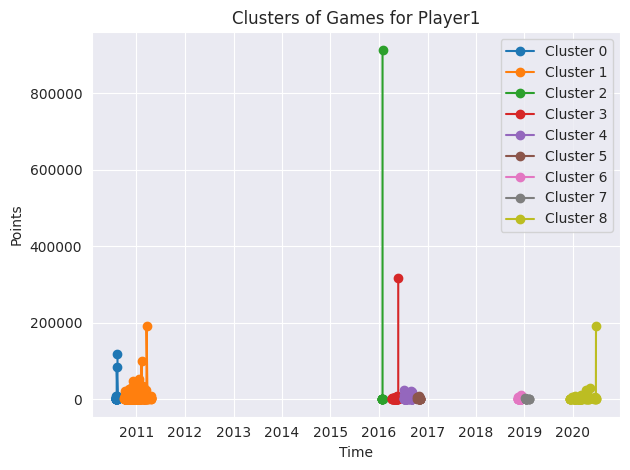

In [6]:
# Step 3: Calculate the time difference (in days) between consecutive games for each player
data['time_diff'] = data.groupby('name')['starttime'].diff().dt.days

# Step 4: Set a threshold for large time gaps (e.g., 30 days)
time_gap_threshold = 30

# Step 5: Label games that have large gaps from the previous game (True for large gaps)
data['large_gap'] = data['time_diff'] > time_gap_threshold

# Step 6: Create clusters of games for each player based on large time gaps
data['cluster'] = data.groupby('name')['large_gap'].cumsum()

# Step 7: Drop 'large_gap' and 'time_diff' columns as they are no longer needed
data = data.drop(columns=['large_gap', 'time_diff'])

# Step 8: Now, you have a 'cluster' column that separates game sequences into clusters for each player
# You can access specific clusters like this:
clusters = data.groupby(['name', 'cluster'])

# Step 9: Example of accessing a specific cluster for a player
player1_clusters = clusters.get_group(('Player1', 1))  # Example: Get cluster 1 for Player1

# You can further analyze or plot the data based on the clusters
# Example: Plot points for Player1's different clusters
player_name = 'Player1'

for cluster_id, group in data[data['name'] == player_name].groupby('cluster'):
    plt.plot(group['starttime'], group['points'], marker='o', label=f'Cluster {cluster_id}')

plt.xlabel('Time')
plt.ylabel('Points')
plt.title(f'Clusters of Games for {player_name}')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Group by player and cluster, calculate summary statistics
cluster_stats = data.groupby(['name', 'cluster']).agg(
    total_points=('points', 'sum'),
    max_level=('maxlvl', 'max'),
    total_turns=('turns', 'sum'),
    game_count=('points', 'count')  # Number of games in the cluster
)

# Create a binary column 'ascended' where 1 means the player ascended and 0 means they did not
data['ascended'] = (data['death'] == 'ascended').astype(int)
# Group by player and cluster, and check if any game in the cluster resulted in ascension
ascension_by_cluster = data.groupby(['name', 'cluster'])['ascended'].max().reset_index()

# Merge this ascension data with the cluster_stats DataFrame
cluster_stats = pd.merge(cluster_stats, ascension_by_cluster, on=['name', 'cluster'], how='left')

# Now 'ascended' is a binary column in cluster_stats where 1 = ascended and 0 = not ascended

cluster_stats

,name,cluster,total_points,max_level,total_turns,game_count,ascended
0,Player0,0,419,6,380,6,1
1,Player0,1,78,2,287,2,0
2,Player0,2,0,1,392,1,0
3,Player0,3,0,1,11,1,0
4,Player0,4,9378,28,218,1,0
...,...,...,...,...,...,...,...
4718,Player9994,2,302957,11,106181,37,0
4719,Player9994,3,4195,5,3789,2,0
4720,Player9994,4,14995,8,6423,4,0
4721,Player9994,5,233740,15,79427,40,0


In [15]:
# Define thresholds based on percentiles
# Define thresholds based on percentiles or domain knowledge
persisting_points_threshold = cluster_stats['total_points'].quantile(0.75)  # Top 25% for persistence
non_persisting_points_threshold = cluster_stats['total_points'].quantile(0.25)  # Bottom 25% for non-persistence

# Apply similar thresholds to other metrics, like max_level or total_turns


def categorize_cluster(row):
    if (row['total_points'] >= persisting_points_threshold) and (row['max_level'] >= 10):  # Example conditions
        return 'persisting'
    elif (row['total_points'] <= non_persisting_points_threshold) and (row['game_count'] < 5):
        return 'non_persisting'
    else:
        return 'neither'

# Apply the refined function to categorize clusters
cluster_stats['persistence_category'] = cluster_stats.apply(categorize_cluster, axis=1)

cluster_stats


,name,cluster,total_points,max_level,total_turns,game_count,ascended,persistence_category
0,Player0,0,419,6,380,6,1,neither
1,Player0,1,78,2,287,2,0,non_persisting
2,Player0,2,0,1,392,1,0,non_persisting
3,Player0,3,0,1,11,1,0,non_persisting
4,Player0,4,9378,28,218,1,0,neither
...,...,...,...,...,...,...,...,...
4718,Player9994,2,302957,11,106181,37,0,persisting
4719,Player9994,3,4195,5,3789,2,0,neither
4720,Player9994,4,14995,8,6423,4,0,neither
4721,Player9994,5,233740,15,79427,40,0,neither


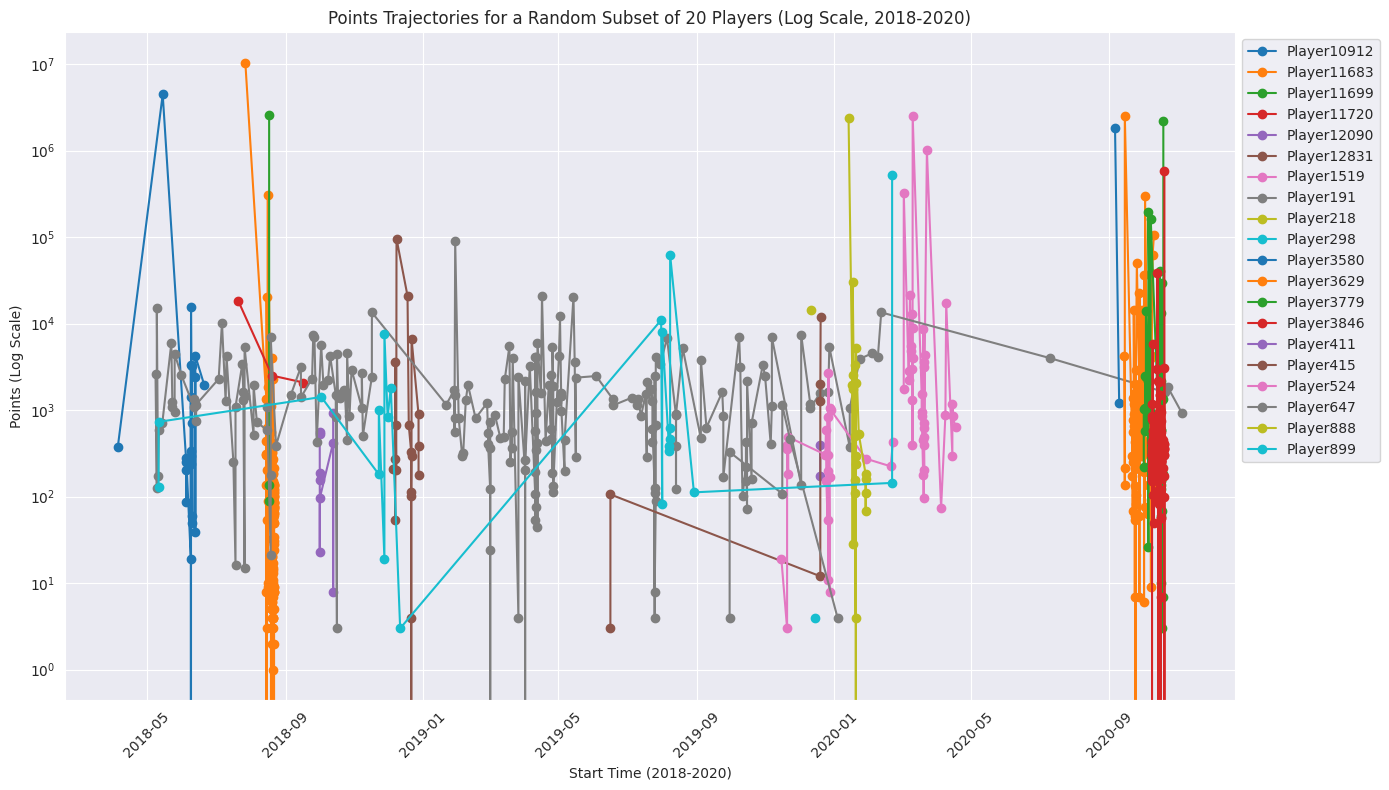

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for games between 2018 and 2020
start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2020-12-31')
filtered_data = data[(data['starttime'] >= start_date) & (data['starttime'] <= end_date)]

# Select a random subset of 20 unique player names from the filtered data
random_players = filtered_data['name'].drop_duplicates().sample(n=20, random_state=42)

# Filter the DataFrame to include only the selected players
subset_data = filtered_data[filtered_data['name'].isin(random_players)]

# Sort the filtered data by player name and starttime
subset_data = subset_data.sort_values(by=['name', 'starttime'])

# Plot with logarithmic y-axis scale
plt.figure(figsize=(14, 8))

# Plot each player's trajectory
for player in subset_data['name'].unique():
    player_data = subset_data[subset_data['name'] == player]
    
    # Plot points over time for the player
    plt.plot(player_data['starttime'], player_data['maxlvl'], marker='o', label=player)

# Apply a logarithmic scale to the y-axis to amplify small changes
plt.yscale('log')

# Add labels and title
plt.xlabel('Start Time (2018-2020)')
plt.ylabel('Points (Log Scale)')
plt.title('Points Trajectories for a Random Subset of 20 Players (Log Scale, 2018-2020)')
plt.xticks(rotation=45)

# Show the legend with player names
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
# Create lag features
data['prev_points'] = data['points'].shift(1)
data['prev_turns'] = data['turns'].shift(1)

# Create the target: whether the next game's points are higher
data['higher_score_next_game'] = (data['points'] > data['prev_points']).astype(int)

# Drop rows with missing values due to shifting
data = data.dropna()

data



,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,realtime,starttime,endtime,gender0,align0,flags,time_difference_y,prev_points,prev_turns,higher_score_next_game
1,3520380,3.4.3,0,0,1,1,-1,11,1,20080322,...,125,2008-03-22 00:07:43,2008-03-22 00:09:50,Mal,Cha,-1,3509 days 20:14:33,0.0,52.0,0
2,3520795,3.4.3,161,0,3,3,15,15,0,20080322,...,106,2008-03-22 22:12:31,2008-03-22 22:14:21,Fem,Cha,-1,3509 days 20:14:33,0.0,10.0,1
3,3521208,3.4.3,250,2,6,6,-17,13,1,20080323,...,632,2008-03-23 11:21:37,2008-03-23 19:35:39,Mal,Cha,-1,3509 days 20:14:33,161.0,308.0,1
4,3521210,3.4.3,3,7,-5,1,16,16,0,20080323,...,46,2008-03-23 19:36:30,2008-03-23 19:37:24,Fem,Neu,-1,3509 days 20:14:33,250.0,8.0,0
5,3521212,3.4.3,5,7,-5,1,10,10,0,20080323,...,43,2008-03-23 19:39:08,2008-03-23 19:39:58,Fem,Neu,-1,3509 days 20:14:33,3.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188287,6536031,3.4.3,2912,2,4,4,-6,37,1,20171028,...,698,2017-10-28 18:01:48,2017-10-28 18:13:26,Mal,Cha,0x0,3996 days 05:15:29,1571.0,1108.0,1
188288,6536204,3.4.3,474,0,2,2,-4,27,1,20171030,...,393,2017-10-30 11:01:08,2017-10-30 11:07:43,Mal,Cha,0x0,3996 days 05:15:29,2912.0,2038.0,0
188289,6536205,3.4.3,93,0,1,1,0,11,1,20171030,...,75,2017-10-30 11:07:46,2017-10-30 11:09:01,Mal,Cha,0x0,3996 days 05:15:29,474.0,1003.0,0
188290,2782906,3.6.0,90,0,1,1,8,11,0,20171102,...,200,2017-11-02 09:45:57,2017-11-02 09:49:18,Mal,Cha,0x4,3996 days 05:15:29,93.0,206.0,0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Define features and target
X = data[['prev_points', 'prev_turns', 'maxlvl']]  # Add more features as needed
y = data['higher_score_next_game']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Get a detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     19333
           1       0.85      0.80      0.82     18326

    accuracy                           0.83     37659
   macro avg       0.83      0.83      0.83     37659
weighted avg       0.83      0.83      0.83     37659



In [14]:
# Ensure 'starttime' is in datetime format
data['starttime'] = pd.to_datetime(data['starttime'], unit='s')

# Sort the data by player name and game starttime
data = data.sort_values(by=['name', 'starttime'])

# Create a new column for the target (whether the next game's score is higher)
data['next_game_higher'] = data.groupby('name')['points'].shift(-1) > data['points']
data['next_game_higher'] = data['next_game_higher'].astype(int)  # Convert boolean to integer (0 or 1)

# Drop the last row for each player, as it doesn't have a "next game"
data = data.dropna(subset=['next_game_higher'])

# Select relevant features for the model
features = ['points', 'turns', 'maxlvl']  # Add more features if needed
target = 'next_game_higher'

In [17]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Ensure 'starttime' is in datetime format
data['starttime'] = pd.to_datetime(data['starttime'], unit='s')

# Sort the data by player name and game starttime
data = data.sort_values(by=['name', 'starttime'])

# Create a new column for the target (whether the next game's score is higher)
data['next_game_higher'] = data.groupby('name')['points'].shift(-1) > data['points']
data['next_game_higher'] = data['next_game_higher'].astype(int)  # Convert boolean to integer (0 or 1)

# Drop the last row for each player, as it doesn't have a "next game"
data = data.dropna(subset=['next_game_higher'])

# Select relevant features for the model
features = ['points', 'turns', 'maxlvl']  # Add more features if needed
target = 'next_game_higher'

# Normalize the feature columns (optional but recommended)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare data for sequence generation
def create_sequences(data, features, target, sequence_length):
    sequences = []
    labels = []
    grouped_data = data.groupby('name')
    
    for name, group in grouped_data:
        values = group[features + [target]].values
        for i in range(len(values) - sequence_length):
            sequence = values[i:i+sequence_length, :-1]  # All columns except target
            label = values[i+sequence_length, -1]  # Target column
            sequences.append(sequence)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

sequence_length = 5
X, y = create_sequences(data, features, target, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)


In [18]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Get the output from the last time step
        last_time_step = lstm_out[:, -1, :]
        
        # Pass it through the fully connected layer
        out = self.fc(last_time_step)
        
        return torch.sigmoid(out)

# Define the model parameters
input_size = len(features)  # Number of features
hidden_size = 64  # Number of LSTM units
output_size = 1  # Binary classification output (0 or 1)
num_layers = 1  # You can experiment with multiple layers

# Create the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Training loop
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    
    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.6937
Epoch [2/20], Loss: 0.6952
Epoch [3/20], Loss: 0.6969
Epoch [4/20], Loss: 0.6974
Epoch [5/20], Loss: 0.6985
Epoch [6/20], Loss: 0.6995
Epoch [7/20], Loss: 0.6999
Epoch [8/20], Loss: 0.6996
Epoch [9/20], Loss: 0.6993
Epoch [10/20], Loss: 0.6993
Epoch [11/20], Loss: 0.6994
Epoch [12/20], Loss: 0.6999
Epoch [13/20], Loss: 0.7005
Epoch [14/20], Loss: 0.7013
Epoch [15/20], Loss: 0.7023
Epoch [16/20], Loss: 0.7036
Epoch [17/20], Loss: 0.7051
Epoch [18/20], Loss: 0.7068
Epoch [19/20], Loss: 0.7089
Epoch [20/20], Loss: 0.7113


In [20]:
# Switch to evaluation mode
model.eval()

# Forward pass on test data
with torch.no_grad():
    y_pred = model(X_test).squeeze()

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).float()

# Calculate accuracy
accuracy = (y_pred_binary == y_test).sum().item() / len(y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5036


In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
class LogisticRegression():
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)
            
            dw = (1/n_samples) *np.dot(X.T, (predictions - y))
            db = (1/n_samples) *np.sum(predictions - y)
            
            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db
        
    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=.5 else 1 for y in y_pred]
        return class_pred

In [13]:
# Define features and target
X = data[['prev_points', 'prev_turns', 'maxlvl']]  # Add more features as needed
y = data['higher_score_next_game']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(lr = .1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test)/len(y_test)
    
acc = accuracy(y_pred, y_test)
print(acc)


KeyError: "['prev_points', 'prev_turns'] not in index"